Learn iterator for elastic problems using MFEANet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time

from utils import plot
from feanet.singlegrid import SingleGrid
from feanet.multigrid import MultiGrid
from feanet.iterator import PsiNet
from feanet.iterator import PsiIterator
from data.dataset import MechanicalDataSet

In [2]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
n_elem = 2**5 # element size on the edge
nb_layers = 3
bs = 5
mode = 'plane_stress'

no_neumann_train = True # not considering Neumann bc for training
no_neumann_test = True # considering Neumann bc for testing
train = False # True or False
model_name = 'dirich_33x33_smoother'
model_dir = 'model/learn_iterator/elastic'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


In [4]:
training_set = MechanicalDataSet('data/data_elasticity/dirich_plate_train_33x33.h5', device)
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=True)
elem_mask_train, node_mask_train, dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, neumann_conn_train, material_train, f_train, u_train = next(iter(train_dataloader))

test_set = MechanicalDataSet('data/data_elasticity/dirich_plate_test_33x33.h5', device)
test_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
elem_mask_test, node_mask_test, dirich_idx_test, dirich_value_test, neumann_idx_test, neumann_value_test, neumann_conn_test, material_test, f_test, u_test = next(iter(test_dataloader))

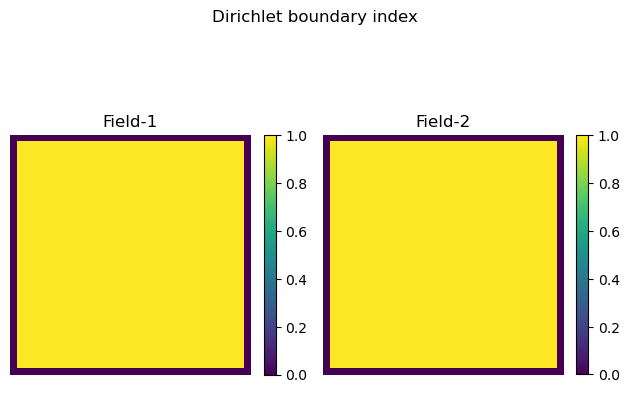

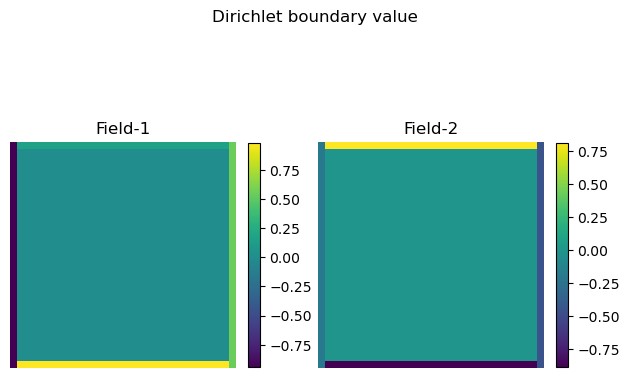

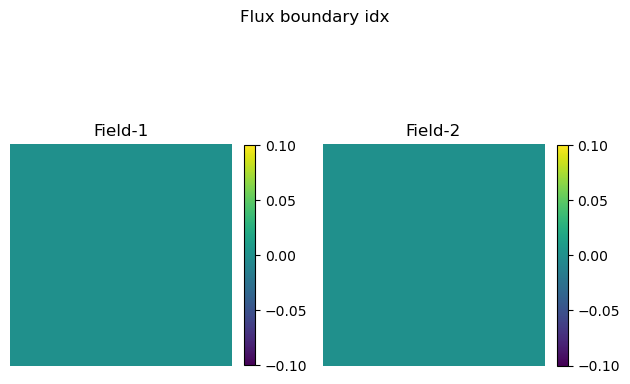

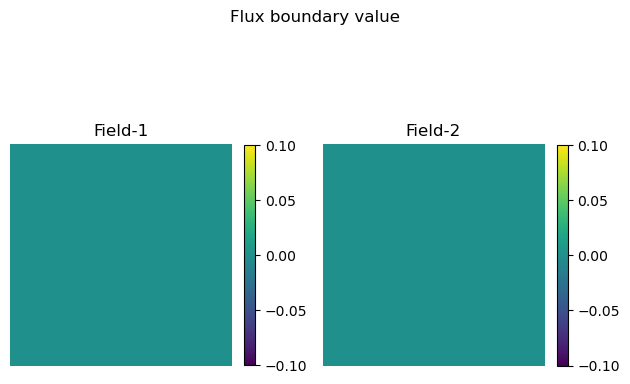

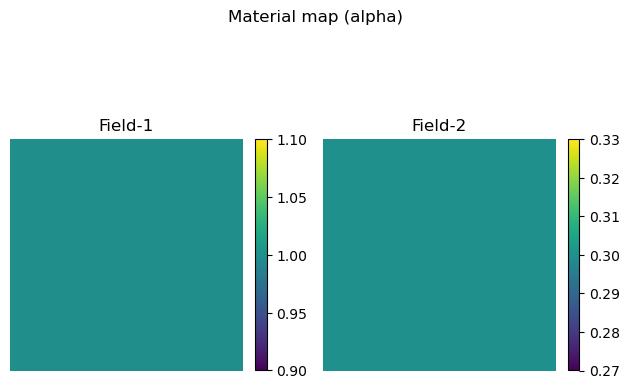

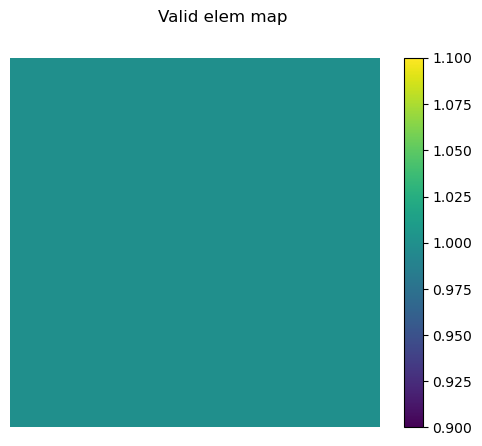

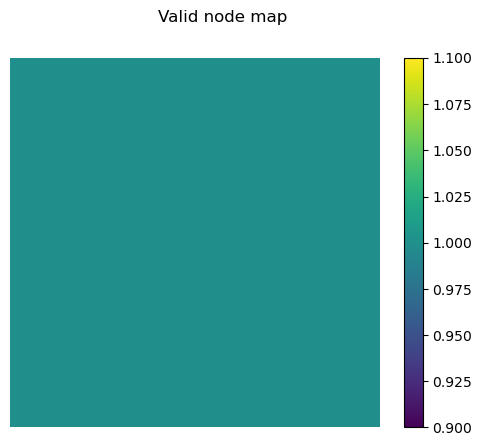

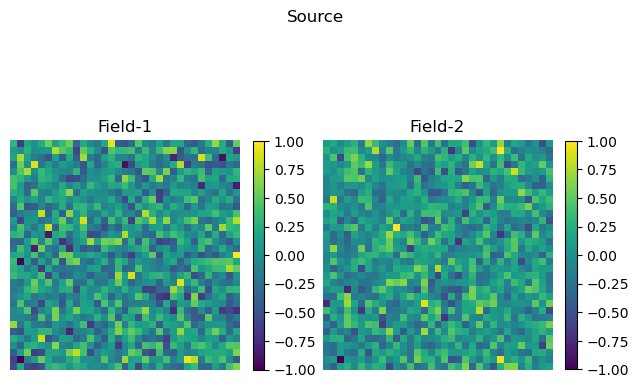

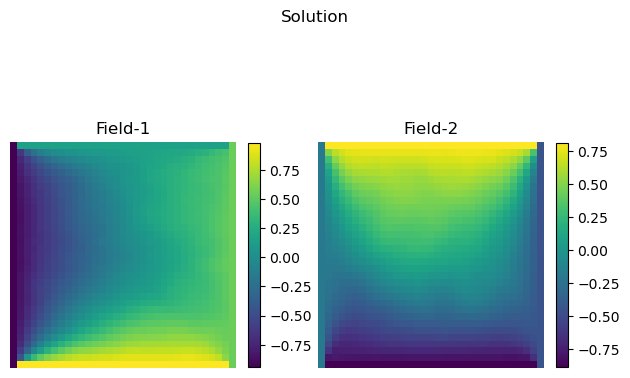

In [5]:
k = 0 # the index of test data to be shown
plot.plot_elasticfield(dirich_idx_test[k], ftitle='Dirichlet boundary index')
plot.plot_elasticfield(dirich_value_test[k], ftitle='Dirichlet boundary value')
plot.plot_elasticfield(neumann_idx_test[k], ftitle='Flux boundary idx')
plot.plot_elasticfield(neumann_value_test[k], ftitle='Flux boundary value')
plot.plot_elasticfield(material_test[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(elem_mask_test[k], ftitle='Valid elem map')
plot.plot_thermalfield(node_mask_test[k], ftitle='Valid node map')
plot.plot_elasticfield(f_test[k], ftitle='Source')
plot.plot_elasticfield(u_test[k], ftitle='Solution')

Create a set of solution data for testing purpose

In [6]:
solution_test, rhs_test, d_test, d_idx_test, t_idx_test, t_test, t_conn_test, m_test, emsk_test, nmsk_test = (torch.unsqueeze(u_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_conn_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(elem_mask_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(node_mask_test[k], 0).to(device_predict))

Test using single grid FEA-Net

In [7]:
hsize = 0.2
ku, kf = 2, 2
grid = SingleGrid(hsize, n_elem=n_elem, mode=mode, dev=device_predict, no_neumann=no_neumann_test)

0 17.389438392742935
1 8.297567541516658
2 5.864686592552817
3 4.655661515721675
4 3.905220504663008
5 3.3852797771065055
6 3.000517552157995
7 2.7027671316613144
8 2.464669785799873
9 2.2694058741818206
10 2.1060179915454746
11 1.967040316918039
12 1.8471995678700632
13 1.7426591122195967
14 1.6505573588074582
15 1.5687143416943117
16 1.4954387918095466
17 1.4293975457043673
18 1.3695248982655164
19 1.314958282973318
20 1.2649917402526496
21 1.2190416701975078
22 1.1766212352788457
23 1.1373209604366825
24 1.1007938430317756
25 1.0667437911730768
26 1.0349165502010058
27 1.0050925113096094
28 0.9770809595717336
29 0.9507154340935909
30 0.9258499557259697
31 0.9023559376888189
32 0.8801196383612749
33 0.8590400479615411
34 0.839027125088772
35 0.8200003173673757
36 0.801887314315831
37 0.7846229911983775
38 0.7681485108334725
39 0.7524105567286764
40 0.7373606759287626
41 0.722954713928695
42 0.7091523271587115
43 0.6959165610774148
44 0.6832134839481847
45 0.6710118680291405
46 0.6592

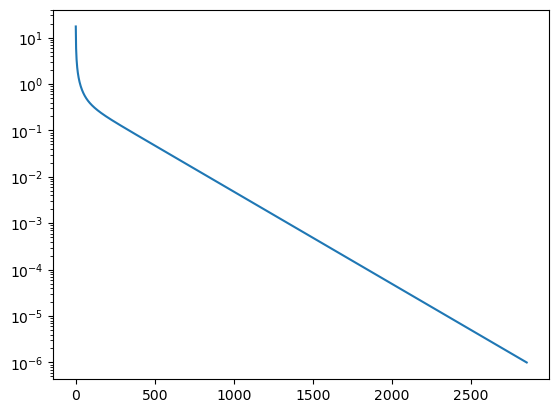

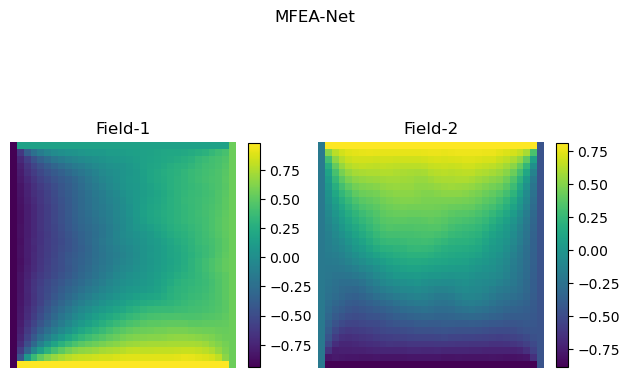

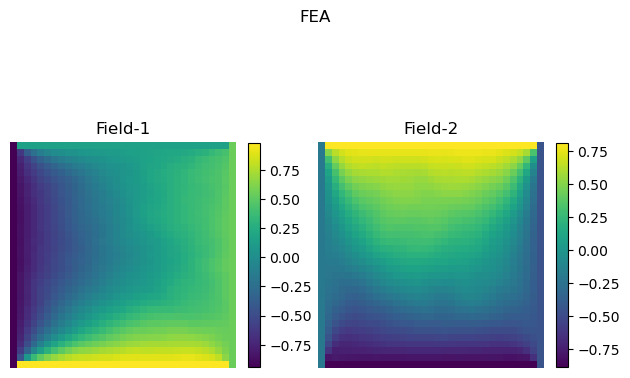

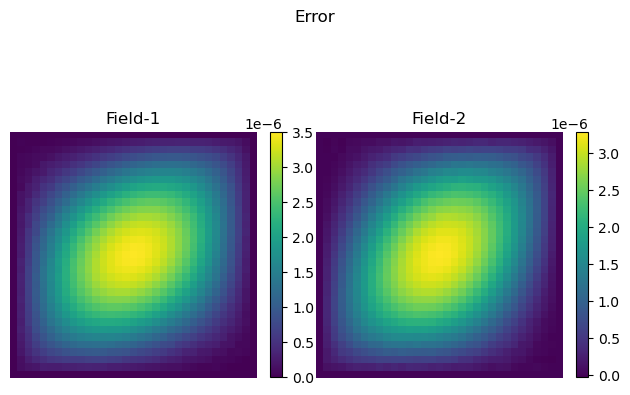

In [8]:
EPS = 1e-6
n_jac = 0
jacu_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
jacu_test = grid.jac.reset_boundary(jacu_test, d_test, d_idx_test)
residual = grid.net(None, None, hsize, jacu_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
res = torch.norm(residual).item() 
res_arr = [res]

if(True):
    print(n_jac, res)
    while (abs(res) > EPS):
        jacu_test = grid.jac.jacobi_convolution(jacu_test, m_test, nmsk_test, d_test, d_idx_test, None, None, hsize, rhs_test, t_test, t_conn_test)
        residual = grid.net(None, None, hsize, jacu_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item() 
        res_arr.append(res)
        n_jac += 1
        print(n_jac, res)

    print("Solution converges after", n_jac, "Jacobi iterations ")
    plt.plot(res_arr)
    plt.yscale('log')
    plt.show()

    plot.plot_elasticfield(jacu_test[0], "MFEA-Net")
    plot.plot_elasticfield(solution_test[0], "FEA")
    plot.plot_elasticfield(jacu_test[0]-solution_test[0], 'Error')

Step-0 loss: 0.33960500467515364
Step-50 loss: 0.16544724703631455
Step-100 loss: 0.16200901370240134
Step-150 loss: 0.16367538451217065
Step-200 loss: 0.16208273521675043
Step-250 loss: 0.1648300607612571
Step-300 loss: 0.16200333302946496
Step-350 loss: 0.16319536054909564
Step-400 loss: 0.16220996827917777
Step-450 loss: 0.1633129666478796
Step-500 loss: 0.1633680769193124
Step-550 loss: 0.16195847978908356
Step-600 loss: 0.16345582477816437
Step-650 loss: 0.16092293388197804
Step-700 loss: 0.16464638849926275
Step-750 loss: 0.1634077068139558
Step-800 loss: 0.1630666816939414
Step-850 loss: 0.16216940350740222
Step-900 loss: 0.16200864226898434
Step-950 loss: 0.16374471130471002
Average loss:  tensor(0.1633) , STD:  tensor(0.0011)


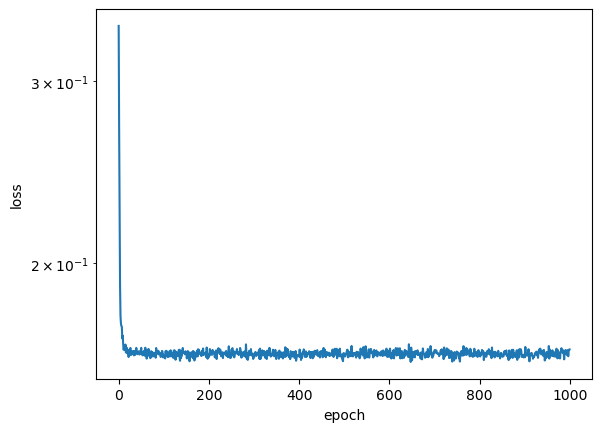

In [9]:
max_epochs = 1000

if(train):
    my_iterator = PsiIterator(device, hsize, n_elem, no_neumann_train, batch_size=bs, mode=mode, iterator='psi', nb_layers=nb_layers, max_epochs=max_epochs)
    loss_train = torch.zeros((max_epochs, 1))
    loss_train = my_iterator.Train(training_set, model_name, model_dir)

    plt.plot(loss_train)
    plt.ylabel('loss')
    plt.yscale('log')
    plt.xlabel('epoch')
    print("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

    # save the list
    torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))


Test the learned smoother

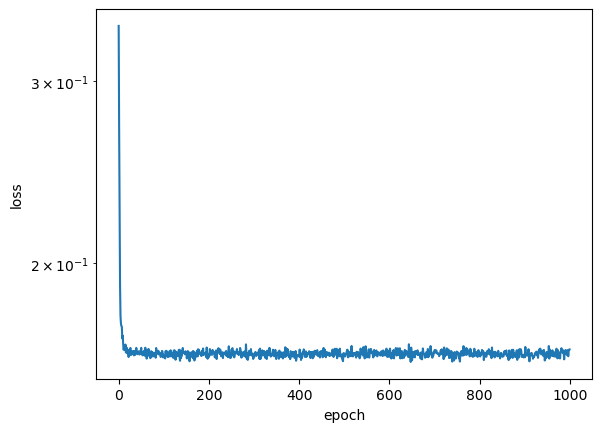

In [10]:
# import the learned model and loss train
my_net = PsiNet(nb_layers=nb_layers, mode=mode).to(device_predict)
my_net.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))
new_iterator = PsiIterator(device_predict, hsize, n_elem, no_neumann_test, psi_net=my_net, grid=grid, nb_layers=nb_layers, batch_size=1, iterator='psi')
my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

In [11]:
list(my_net.parameters())

[Parameter containing:
 tensor([[[[ 5.8659e-01,  6.4416e-01,  4.1549e-01],
           [ 2.5502e-01,  3.8319e-01,  1.7502e-01],
           [ 7.4284e-02,  1.0914e-01,  3.7822e-02]],
 
          [[ 9.1230e-03, -4.4191e-02,  8.4462e-02],
           [ 4.5209e-03,  1.7883e-01, -1.3479e-01],
           [ 9.7452e-04,  4.1911e-03,  3.6005e-02]]],
 
 
         [[[-3.3916e-01,  2.7607e-02,  2.3109e-01],
           [ 2.4609e-01, -7.2038e-02, -1.6000e-01],
           [ 4.4691e-02,  2.3733e-02, -8.2323e-02]],
 
          [[ 9.3787e-02,  7.3724e-01,  6.9887e-02],
           [ 3.6400e-02,  1.0121e+00, -7.2739e-02],
           [ 7.3766e-02,  3.0777e-01,  1.7395e-01]]]], dtype=torch.float64,
        requires_grad=True),
 Parameter containing:
 tensor([[[[ 0.0789, -0.0786, -0.0130],
           [-0.2250,  0.2118, -0.0145],
           [ 0.0318, -0.2163, -0.1989]],
 
          [[ 0.1965,  0.1652,  0.1374],
           [ 0.0161,  0.6086,  0.0531],
           [ 0.1361,  0.6178,  0.1846]]],
 
 
         [[[ 0.0

0 17.389438392742935
1 4.721202261363092
2 1.4780356191223298
3 1.0019906388952173
4 0.789544380406814
5 0.6625877982633057
6 0.5737075311449963
7 0.5082767012198539
8 0.4579141469572337
9 0.41774320832321743
10 0.38471932300651684
11 0.3568878759750625
12 0.33295315407357
13 0.3120298439224702
14 0.29349407092088853
15 0.2768928003734841
16 0.2618877568747322
17 0.24822005063010133
18 0.23568735393193413
19 0.22412878256556865
20 0.21341458628198873
21 0.2034389048997098
22 0.19411452926097567
23 0.18536901189784738
24 0.1771417146047525
25 0.16938152622697394
26 0.16204507329016093
27 0.15509530174433375
28 0.1485003436267599
29 0.14223260580398991
30 0.1362680338057668
31 0.13058551487947465
32 0.1251663924317206
33 0.11999406999480935
34 0.11505368739156609
35 0.11033185527780814
36 0.10581643698726137
37 0.10149636877427291
38 0.09736151127732308
39 0.09340252640797284
40 0.08961077497847733
41 0.08597823127291374
42 0.08249741148500978
43 0.0791613135253701
44 0.07596336616883533

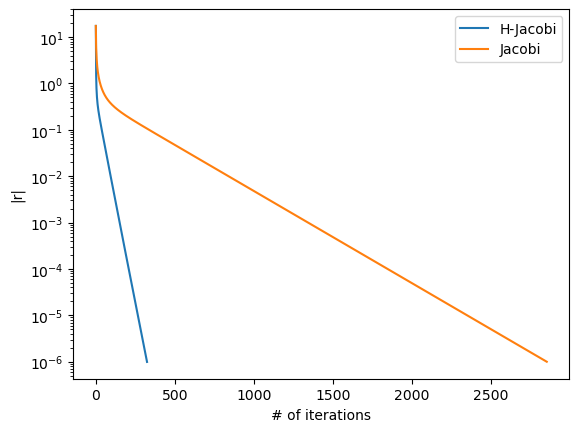

In [12]:
EPS = 1e-6
with torch.no_grad():
    n_new = 0
    u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
    u_test = new_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
    residual = new_iterator.grid.net(None, None, hsize, u_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
    res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
    res_arr_new = [res]
    print(n_new, res)
    while (abs(res) > EPS):
        u_test = new_iterator.PsiRelax(u_test, m_test, nmsk_test, d_test, d_idx_test, None, None, hsize, rhs_test, t_test, t_conn_test, 1)
        residual = new_iterator.grid.net(None, None, hsize, u_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_new.append(res)
        n_new += 1
        print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new, label='H-Jacobi')
plt.plot(res_arr, label='Jacobi')
plt.ylabel('|r|')
plt.xlabel('# of iterations')
plt.yscale('log')
plt.legend()
plt.savefig('results/jac_res.jpg', dpi=500, bbox_inches='tight')
plt.show()

In [22]:
with torch.no_grad():
    n = n_elem
    n_mg_jac = 0
    mg_jac = MultiGrid(hsize, n, no_neumann_test, pacnet=None, device=device, nb_layers=nb_layers, mode=mode, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(rhs_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_jac = torch.ones((1, ku, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, hsize, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test,nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, hsize, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


0 17.389438392742935
1 2.7236506467565427
2 1.2699821109108902
3 0.6586213689826094
4 0.3494274680584044
5 0.18666661605558432
6 0.09999095546396583
7 0.05363392071221699
8 0.028791268269379798
9 0.015463669312959186
10 0.00830879264005435
11 0.0044658666448097835
12 0.0024010323780032294
13 0.0012912307782111288
14 0.0006945709526891087
15 0.0003737077248880028
16 0.00020111645864820754
17 0.00010825839151104976
18 5.828715912795909e-05
19 3.1389245491554745e-05
20 1.6907720136157526e-05
21 9.109300562071332e-06
22 4.908858092942922e-06
23 2.64588542897319e-06
24 1.4264492035664083e-06
25 7.691939436941954e-07
Solution converges after 25 Jacobi multigrid iterations in 0.08813095092773438 seconds.


In [21]:
with torch.no_grad():
    n = n_elem
    n_mg_psi = 0
    mg_psi = MultiGrid(hsize, n, no_neumann_test, pacnet=my_net, device=device, nb_layers=nb_layers, mode=mode, iterator='psi') # create a multigrid model
    mg_psi.ProblemDictArray(rhs_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_psi = torch.ones((1, ku, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_psi = mg_psi.iterators[0].grid.jac.reset_boundary(u_mg_psi, d_test, d_idx_test)
    residual = mg_psi.iterators[0].grid.net(None, None, hsize, u_mg_psi, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgpsi = [res]
    print(n_mg_psi, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_psi = mg_psi.Step(u_mg_psi)
        residual = mg_psi.iterators[0].grid.net(None, None, hsize, u_mg_psi, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_mgpsi.append(res)
        n_mg_psi += 1
        print(n_mg_psi, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_psi, "Psi-Jacobi multigrid iterations in", end-start, 'seconds.')


0 17.389438392742935
1 0.7395863525799534
2 0.10298573285943545
3 0.036463574254540644
4 0.014219025925610673
5 0.0057450452800959775
6 0.002376007312917979
7 0.0009991968063565175
8 0.0004254971286509941
9 0.00018296838629826013
10 7.92945193277481e-05
11 3.4584748956069804e-05
12 1.5165035728919065e-05
13 6.67992233133561e-06
14 2.953916843002973e-06
15 1.310722505443387e-06
16 5.833620285884923e-07
Solution converges after 16 Psi-Jacobi multigrid iterations in 0.0780029296875 seconds.


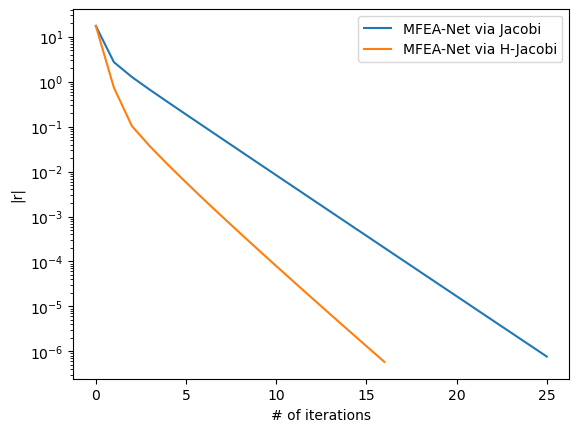

In [15]:
plt.plot(res_arr_mgjac, label='MFEA-Net via Jacobi')
plt.plot(res_arr_mgpsi, label='MFEA-Net via H-Jacobi')
plt.yscale('log')
plt.legend()
plt.ylabel('|r|')
plt.xlabel('# of iterations')
plt.savefig('results/multigrid_res.jpg', dpi=500, bbox_inches='tight')
plt.show()

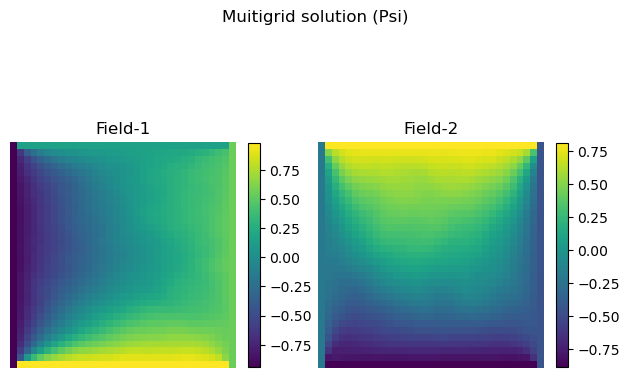

In [16]:
plot.plot_elasticfield(u_mg_psi[0], 'Muitigrid solution (Psi)')

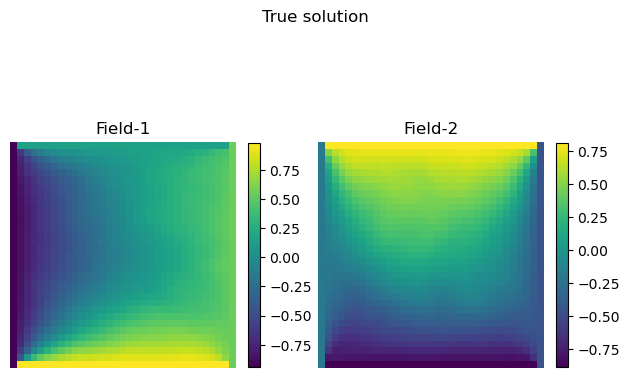

In [17]:
plot.plot_elasticfield((solution_test[0]), 'True solution')

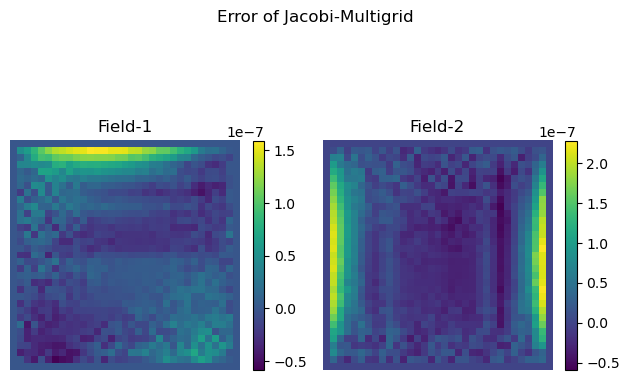

In [18]:
plot.plot_elasticfield(u_mg_jac[0]-solution_test[0], 'Error of Jacobi-Multigrid')

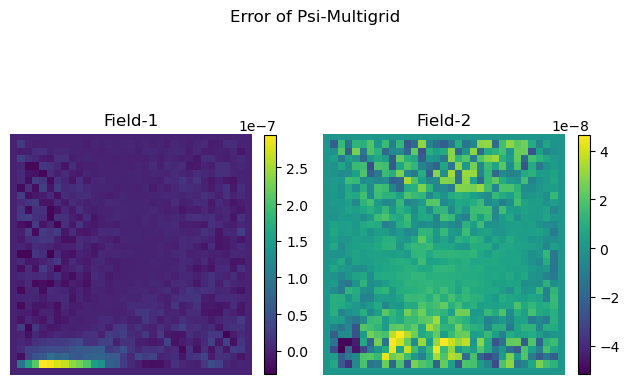

In [19]:
plot.plot_elasticfield(u_mg_psi.detach()[0]-solution_test[0], 'Error of Psi-Multigrid')